### Imports

In [1]:
from time import strftime
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add, Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import pydot
import graphviz
from keras.utils import plot_model
from keras.engine.topology import Layer

/Users/andrey/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# SMS alerts
## CHANGE IFNO!  so you dont spam Andrey
Can change `account_sid`, `auth_token`, `to` and `from` to info from a FREE twilio account (super easy to set up give you ~2k free sms)

In [2]:
from twilio.rest import Client

class DoneAlert(keras.callbacks.Callback):
    def on_train_end(self, logs={}):
        account_sid = "ACdb60c905cd24f1bd71e6b49efb7a75c4"
        auth_token = "607eb22c4134ad6904ce2ad87d066e58"
        to = "+19258587735"
#         to = "+15102900156"
        from_ = "+16504828933"
        client = Client(account_sid, auth_token)
        
        max_val_acc = max(self.model.history.history['val_acc'])
        min_val_loss = min(model.history.history['val_loss'])
        msg = "Training Ended. val_acc="+str(max_val_acc)+' \n min val_loss=' + str(min_val_loss)
        message = client.messages.create(to=to, from_=from_, body=msg)

## Data generators
* define image size, 50 seem to work fine
* define batch size for which images will be read from the folder
* define training and validation data location, `proccesse_data` has all images, `proccessed_data_equal_number_of_sam` has equal amount of male and female data points (makes baseline accuracy 0.5, datapoints were discarded randomly)

In [82]:
img_width = 100
img_height = 100

batch_size = 64

train_data_dir = './datasets/equal_data/gender/train/'
valid_data_dir = './datasets/equal_data/gender/valid/'

In [83]:
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
#     save_to_dir='./transformed_images'

Found 17512 images belonging to 2 classes.


In [84]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    color_mode='grayscale',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 1944 images belonging to 2 classes.


In [85]:
num_samples=train_generator.samples
num_classes=train_generator.num_classes
num_men = sum(train_generator.classes ==1)
num_woman = sum(train_generator.classes ==0)
print("num woman:", num_woman)
print("num men:", num_men)

num woman: 8756
num men: 8756


In [86]:
num_valid=valid_generator.samples
print("number of validation samples:", num_valid)

number of validation samples: 1944


## Define model hyper parameters:
Model has stages, each stage with different number of Residual Layers, and different number of filters per layer.
#### Define:
* number of filters per stage.
* number of residual layers per stage, each layer has one residual connection and two (BatchNorm) -> (ReLu) -> (BatchNorm) -> (Relu) -> (Conv2D)
* define how many FC layers and their size
* define dropout rate

In [87]:
# Number of network stages, each stage with different number of filters
stage_filters = [1]

# depth of each stage
stage_depth = [1]

assert len(stage_filters) == len(stage_depth)

num_stages = len(stage_filters)
dense_depth = 1
dense_size = 256

drop_prob = 0.5

## Define Network

In [88]:
inputs = Input(shape=train_generator.image_shape)

x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(filters=stage_filters[0], kernel_size=7, strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=stage_filters[0], kernel_size=7,  padding='same')(x)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

res = x
for stage in range(num_stages):
    filters = stage_filters[stage]
    depth = stage_depth[stage]
    
    # halves residual spatial dimentions to match main branch shape
    if stage != 0:
        res = Conv2D(filters=filters, kernel_size=(1, 1), strides=2, padding='same')(res)
        
    for i in range(depth):        
        # First resnet layer
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        # halve the spatial dimentions every time number of filters doubles, but not in the first stage
        if i == 0 and stage != 0: 
            x = Conv2D(filters=filters, kernel_size=3, padding='same', strides=(2, 2))(x)
        else:
            x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        
        # Second resnet layer
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = Add()([x, res])
        res = x
    
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(drop_prob)(x)

for _ in range(dense_depth):
    x = Dense(dense_size, activation='relu')(x)
    
predictions = Dense(1, activation='sigmoid')(x)

In [89]:
model = Model(inputs=inputs, outputs=predictions)

## Visualize model 
(writes to file)

In [90]:
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=False)

### Compile

In [91]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])

### Load weights (if resuming a trainning session)
Commented out for convinience

In [92]:
# model.load_weights('./weights/Sat_14_Apr_2018_19_14_37.hdf5')

# Train
* define number of epochs
* define callbacks: 
    * `checkpointer` saves the weights after each epoch, iff validation loss went down.
    * `reduce_lr` reduces learning rate if validation loss plareus.

In [93]:
epochs = 1

In [94]:
checkpointer = ModelCheckpoint(filepath='./weights/{}.hdf5'.format(strftime("%a_%d_%b_%Y_%H_%M_%S")), verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001, verbose=1)
# tensorboard = TensorBoard(log_dir="./logs/{}".format(strftime("%a, %d %b %Y %H:%M:%S")))
sms_alert = DoneAlert()
# callbacks = [reduce_lr, checkpointer, sms_alert]
# callbacks = [reduce_lr, checkpointer]
callbacks = [reduce_lr]

history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              validation_steps=num_valid//batch_size,
                              steps_per_epoch=num_samples//batch_size, 
                              epochs=epochs,
                              callbacks=callbacks,
                              verbose=1,
                              use_multiprocessing=True,
                              workers=4)

Epoch 1/1
273/273 [==============================] - 144s 529ms/step - loss: 0.6622 - acc: 0.6045 - val_loss: 0.6249 - val_acc: 0.6604


# screwing around area

In [20]:
val_loss, val_acc, loss, acc, lr = model.history.history.values()

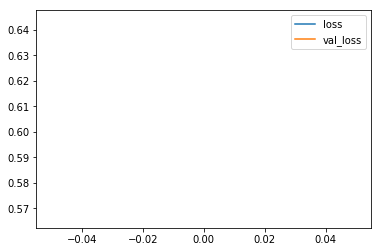

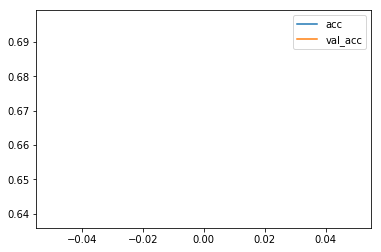

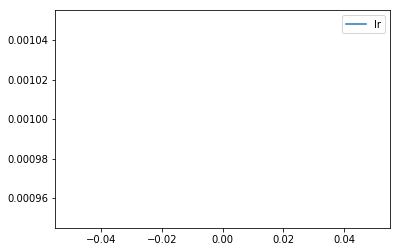

In [21]:
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.show()
plt.plot(lr, label="lr")
plt.legend()
plt.show()

In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 100, 100, 1)  4           input_8[0][0]                    
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 100, 100, 1)  0           batch_normalization_239[0][0]    
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 50, 50, 1)    50          activation_239[0][0]             
__________________________________________________________________________________________________
batch_norm